
# PyTorch Backend Example: Multi-Graph Matching

This example shows how to match multiple graphs. Multi-graph matching means that more than two graphs are jointly
matched.


In [ ]:
# Author: Zetian Jiang <maple_jzt@sjtu.edu.cn>
#         Ziao Guo <ziao.guo@sjtu.edu.cn>
#
# License: Mulan PSL v2 License

<div class="alert alert-info"><h4>Note</h4><p>The following solvers are included in this example:

    * :func:`~pygmtools.classic_solvers.rrwm` (classic solver)

    * :func:`~pygmtools.multi_graph_solvers.cao` (classic solver)

    * :func:`~pygmtools.multi_graph_solvers.mgm_floyd` (classic solver)</p></div>




In [1]:
import os
import time
import math
import copy
import torch  # pytorch backend
import itertools
import numpy as np
import pygmtools as pygm
import matplotlib.pyplot as plt  # for plotting
import scipy.io as sio  # for loading .mat file
import scipy.spatial as spa  # for Delaunay triangulation

from PIL import Image
from matplotlib.patches import ConnectionPatch # for plotting matching result

pygm.set_backend('pytorch')  # set default backend for pygmtools

## Load the images
Images are from the Willow Object Class dataset (this dataset also available with the Benchmark of ``pygmtools``,
see :class:`~pygmtools.dataset.WillowObject`).

The images are resized to 256x256.




In [2]:
obj_resize = (256, 256)
n_images = 30
n_outlier = 0
img_list = []
kpts_list = []
n_kpts_list = []
perm_list = []

bm = pygm.benchmark.Benchmark(name='WillowObject', 
                              sets='train', 
                              obj_resize=obj_resize)

while len(img_list) < n_images:
    data_list, gt_dict, _ = bm.rand_get_data(cls='Car')
    for data in data_list:
        img = Image.fromarray(data['img'])
        coords = sorted(data['kpts'], key=lambda x: x['labels'])
        kpts = torch.tensor([[kpt['x'] for kpt in coords], 
                        [kpt['y'] for kpt in coords]])
        perm = np.eye(kpts.shape[1])
        img_list.append(img)
        kpts_list.append(kpts)
        n_kpts_list.append(kpts.shape[1])
        perm_list.append(perm)

Visualize the images and keypoints




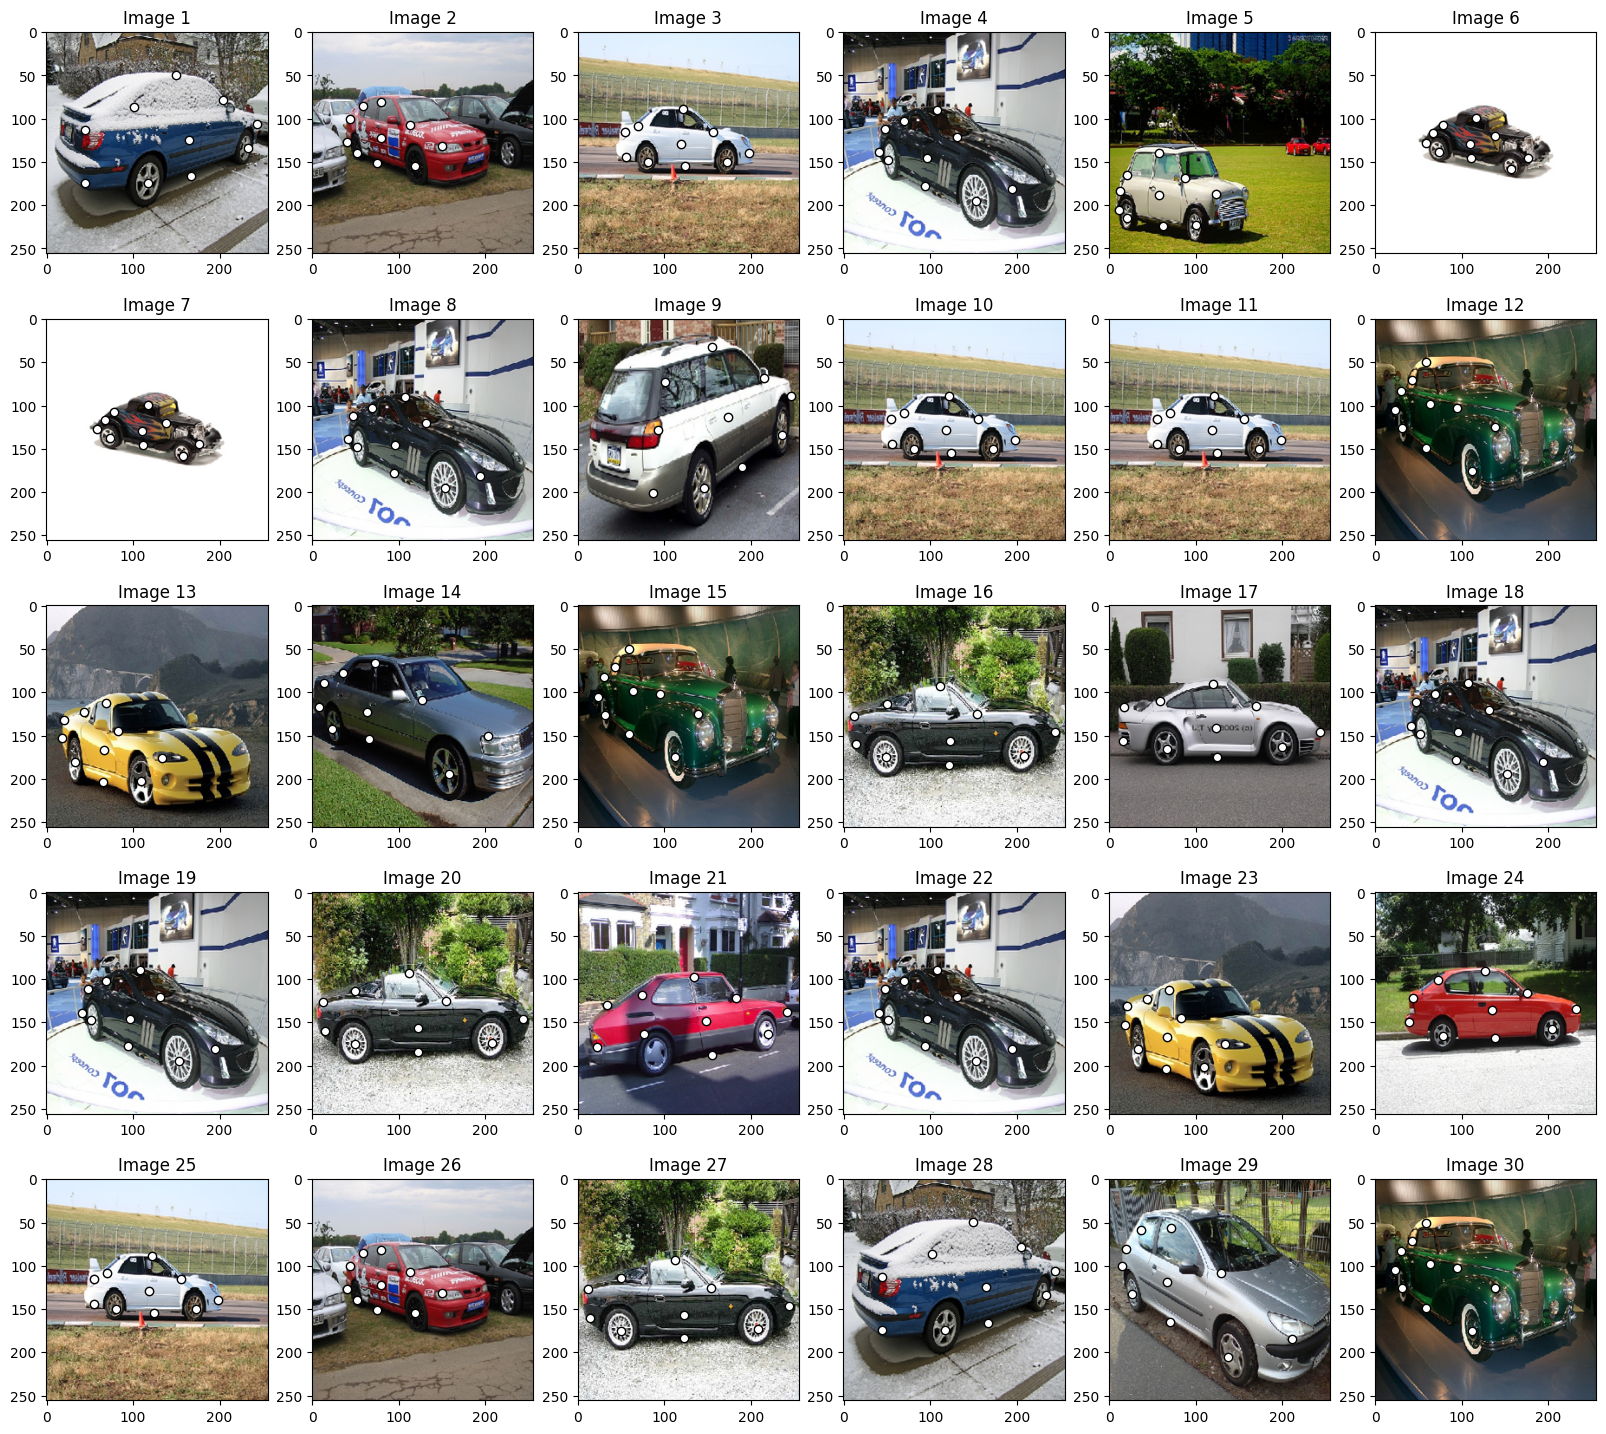

In [3]:
def plot_image_with_graph(img, kpt, A=None):
    plt.imshow(img)
    plt.scatter(kpt[0], kpt[1], c='w', edgecolors='k')
    if A is not None:
        for idx in torch.nonzero(A, as_tuple=False):
            plt.plot((kpt[0, idx[0]], kpt[0, idx[1]]), (kpt[1, idx[0]], kpt[1, idx[1]]), 'k-')


plt.figure(figsize=(20, 18))
for i in range(n_images):
    plt.subplot(5, n_images // 5, i + 1)
    plt.title('Image {}'.format(i + 1))
    plot_image_with_graph(img_list[i], kpts_list[i])
# plt.savefig('image')
# plt.close()

## Build the graphs
Graph structures are built based on the geometric structure of the keypoint set. In this example,
we refer to [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation).




In [4]:
def delaunay_triangulation(kpt):
    d = spa.Delaunay(kpt.numpy().transpose())
    A = torch.zeros(len(kpt[0]), len(kpt[0]))
    for simplex in d.simplices:
        for pair in itertools.permutations(simplex, 2):
            A[pair] = 1
    return A


adj_list = []
for i in range(n_images):
    A = delaunay_triangulation(kpts_list[i])
    adj_list.append(A)

## Build affinity matrix
We follow the formulation of Quadratic Assignment Problem (QAP):

\begin{align}&\max_{\mathbf{X}} \ \texttt{vec}(\mathbf{X})^\top \mathbf{K} \texttt{vec}(\mathbf{X})\\
    s.t. \quad &\mathbf{X} \in \{0, 1\}^{n_1\times n_2}, \ \mathbf{X}\mathbf{1} = \mathbf{1}, \ \mathbf{X}^\top\mathbf{1} \leq \mathbf{1}\end{align}

where the first step is to build the affinity matrix ($\mathbf{K}$) for each pair of graphs




In [5]:
def get_feature(n, points, adj):
    """
    :param n: points # of graph
    :param points: torch tensor, (n, 2)
    :param adj: torch tensor, (n, n)
    :return: edge feat, angle feat
    """
    points_1 = points.reshape(n, 1, 2).repeat(1, n, 1)
    points_2 = points.reshape(1, n, 2).repeat(n, 1, 1)
    edge_feat = torch.sqrt(torch.sum((points_1 - points_2) ** 2, dim=2))
    edge_feat = edge_feat / torch.max(edge_feat)
    angle_feat = torch.atan((points_1[:, :, 1] - points_2[:, :, 1]) / (points_1[:, :, 0] - points_2[:, :, 0] + 1e-8))
    angle_feat = 2 * angle_feat / math.pi

    return edge_feat, angle_feat


def get_pair_affinity(edge_feat_1, angle_feat_1, edge_feat_2, angle_feat_2, adj1, adj2):
    n1, n2 = edge_feat_1.shape[0], edge_feat_2.shape[0]
    assert n1 == angle_feat_1.shape[0] and n2 == angle_feat_2.shape[0]

    left_adj = adj1.reshape(n1, n1, 1, 1).repeat(1, 1, n2, n2)
    right_adj = adj2.reshape(1, 1, n2, n2).repeat(n1, n1, 1, 1)
    adj = left_adj * right_adj

    left_edge_feat = edge_feat_1.reshape(n1, n1, 1, 1, -1).repeat(1, 1, n2, n2, 1)
    right_edge_feat = edge_feat_2.reshape(1, 1, n2, n2, -1).repeat(n1, n1, 1, 1, 1)
    edge_weight = torch.sqrt(torch.sum((left_edge_feat - right_edge_feat) ** 2, dim=-1))

    left_angle_feat = angle_feat_1.reshape(n1, n1, 1, 1, -1).repeat(1, 1, n2, n2, 1)
    right_angle_feat = angle_feat_2.reshape(1, 1, n2, n2, -1).repeat(n1, n1, 1, 1, 1)
    angle_weight = torch.sqrt(torch.sum((left_angle_feat - right_angle_feat) ** 2, dim=-1))

    affinity = edge_weight * 0.9 + angle_weight * 0.1
    affinity = torch.exp(-affinity / 0.1) * adj
    affinity = affinity.transpose(1, 2)

    return affinity


def generate_affinity_matrix(n_points, points_list, adj_list):
    m = len(n_points)
    n_max = max(n_points)
    affinity = torch.zeros(m, m, n_max, n_max, n_max, n_max)

    edge_feat_list = []
    angle_feat_list = []
    for n, points, adj in zip(n_points, points_list, adj_list):
        edge_feat, angle_feat = get_feature(n, points, adj)
        edge_feat_list.append(edge_feat)
        angle_feat_list.append(angle_feat)

    for i, j in itertools.product(range(m), range(m)):
        pair_affinity = get_pair_affinity(edge_feat_list[i],
                                          angle_feat_list[i],
                                          edge_feat_list[j],
                                          angle_feat_list[j],
                                          adj_list[i],
                                          adj_list[j])
        affinity[i, j] = pair_affinity

    affinity = affinity.permute(0, 1, 3, 2, 5, 4).reshape(m, m, n_max * n_max, n_max * n_max)
    return affinity


affinity_mat = generate_affinity_matrix(n_kpts_list, kpts_list, adj_list)

m = len(kpts_list)
n = int(torch.max(torch.tensor(n_kpts_list)))
ns_src = torch.ones(m * m).int() * n
ns_tgt = torch.ones(m * m).int() * n

Calculate accuracy, consistency, and affinity



In [6]:
def cal_accuracy(mat, gt_mat, n):
    m = mat.shape[0]
    acc = 0
    for i in range(m):
        for j in range(m):
            _mat, _gt_mat = mat[i, j], gt_mat[i, j]
            row_sum = torch.sum(_gt_mat, dim=0)
            col_sum = torch.sum(_gt_mat, dim=1)
            row_idx = [k for k in range(n) if row_sum[k] != 0]
            col_idx = [k for k in range(n) if col_sum[k] != 0]
            _mat = _mat[row_idx, :]
            _mat = _mat[:, col_idx]
            _gt_mat = _gt_mat[row_idx, :]
            _gt_mat = _gt_mat[:, col_idx]
            acc += 1 - torch.sum(torch.abs(_mat - _gt_mat)) / 2 / (n - n_outlier)
    return acc / (m * m)


def cal_consistency(mat, gt_mat, m, n):
    return torch.mean(get_batch_pc_opt(mat))


def cal_affinity(X, X_gt, K, m, n):
    X_batch = X.reshape(-1, n, n)
    X_gt_batch = X_gt.reshape(-1, n, n)
    K_batch = K.reshape(-1, n * n, n * n)
    affinity = get_batch_affinity(X_batch, K_batch)
    affinity_gt = get_batch_affinity(X_gt_batch, K_batch)
    return torch.mean(affinity / (affinity_gt + 1e-8))


def get_batch_affinity(X, K, norm=1):
    """
    calculate affinity score
    :param X: (b, n, n)
    :param K: (b, n*n, n*n)
    :param norm: normalization term
    :return: affinity_score (b, 1, 1)
    """
    b, n, _ = X.size()
    vx = X.transpose(1, 2).reshape(b, -1, 1)  # (b, n*n, 1)
    vxt = vx.transpose(1, 2)  # (b, 1, n*n)
    affinity = torch.bmm(torch.bmm(vxt, K), vx) / norm
    return affinity


def get_single_affinity(X, K, norm=1):
    """
    calculate affinity score
    :param X: (n, n)
    :param K: (n*n, n*n)
    :param norm: normalization term
    :return: affinity_score scale
    """
    n, _ = X.size()
    vx = X.transpose(0, 1).reshape(-1, 1)
    vxt = vx.transpose(0, 1)
    affinity = torch.matmul(torch.matmul(vxt, K), vx) / norm
    return affinity


def get_single_pc(X, i, j, Xij=None):
    """
    :param X: (m, m, n, n) all the matching results
    :param i: index
    :param j: index
    :param Xij: (n, n) matching
    :return: the consistency of X_ij
    """
    m, _, n, _ = X.size()
    if Xij is None:
        Xij = X[i, j]
    pair_con = 0
    for k in range(m):
        X_combo = torch.matmul(X[i, k], X[k, j])
        pair_con += torch.sum(torch.abs(Xij - X_combo)) / (2 * n)
    return 1 - pair_con / m


def get_single_pc_opt(X, i, j, Xij=None):
    """
    :param X: (m, m, n, n) all the matching results
    :param i: index
    :param j: index
    :return: the consistency of X_ij
    """
    m, _, n, _ = X.size()
    if Xij is None:
        Xij = X[i, j]
    X1 = X[i, :].reshape(-1, n, n)
    X2 = X[:, j].reshape(-1, n, n)
    X_combo = torch.bmm(X1, X2)
    pair_con = 1 - torch.sum(torch.abs(Xij - X_combo)) / (2 * n * m)
    return pair_con


def get_batch_pc(X):
    """
    :param X: (m, m, n, n) all the matching results
    :return: (m, m) the consistency of X
    """
    pair_con = torch.zeros(m, m).cuda()
    for i in range(m):
        for j in range(m):
            pair_con[i, j] = get_single_pc_opt(X, i, j)
    return pair_con


def get_batch_pc_opt(X):
    """
    :param X: (m, m, n, n) all the matching results
    :return: (m, m) the consistency of X
    """
    m, _, n, _ = X.size()
    X1 = X.reshape(m, 1, m, n, n).repeat(1, m, 1, 1, 1).reshape(-1, n, n)  # X1[i, j, k] = X[i, k]
    X2 = X.reshape(1, m, m, n, n).repeat(m, 1, 1, 1, 1).transpose(1, 2).reshape(-1, n, n)  # X2[i, j, k] = X[k, j]
    X_combo = torch.bmm(X1, X2).reshape(m, m, m, n, n)
    X_ori = X.reshape(m, m, 1, n, n).repeat(1, 1, m, 1, 1)
    pair_con = 1 - torch.sum(torch.abs(X_combo - X_ori), dim=(2, 3, 4)) / (2 * n * m)
    return pair_con


def eval(mat, gt_mat, affinity, m, n):
    acc = cal_accuracy(mat, gt_mat, n)
    src = cal_affinity(mat, gt_mat, affinity, m, n)
    con = cal_consistency(mat, gt_mat, m, n)
    return acc, src, con

Generate gt mat



In [7]:
gt_mat = torch.zeros(m, m, n, n)
for i in range(m):
    for j in range(m):
        gt_mat[i, j] = torch.tensor(np.matmul(perm_list[i].transpose(0, 1), perm_list[j]))
print(perm_list[0])
print(perm_list[1])
print(gt_mat[1, 2])
print(gt_mat[0, 1] - gt_mat[1, 0].transpose(0, 1))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0

## Pairwise graph matching by RRWM
See :func:`~pygmtools.classic_solvers.rrwm` for the API reference.




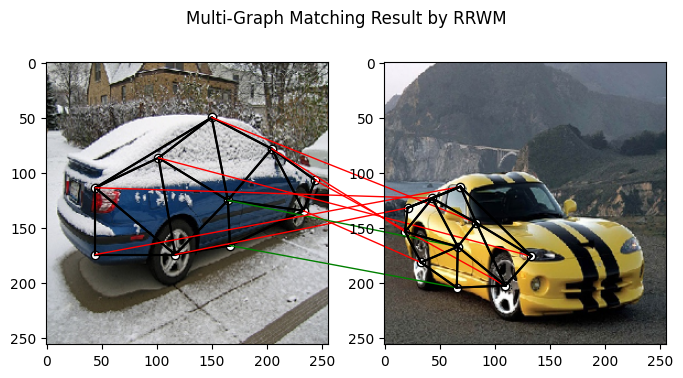

In [8]:
a = 0
b = 12
tic = time.time()
rrwm_mat = pygm.classic_solvers.rrwm(affinity_mat.reshape(-1, n * n, n * n), ns_src, ns_tgt)
rrwm_mat = pygm.linear_solvers.hungarian(rrwm_mat)
toc = time.time()
rrwm_mat = rrwm_mat.reshape(m, m, n, n)
rrwm_acc, rrwm_src, rrwm_con = eval(rrwm_mat, gt_mat, affinity_mat, m, n)
rrwm_tim = toc - tic

plt.figure(figsize=(8, 4))
plt.suptitle('Multi-Graph Matching Result by RRWM')
ax1 = plt.subplot(1, 2, 1)
plot_image_with_graph(img_list[a], kpts_list[a], adj_list[a])
ax2 = plt.subplot(1, 2, 2)
plot_image_with_graph(img_list[b], kpts_list[b], adj_list[b])
X = rrwm_mat[a, b]
for i in range(X.shape[0]):
    j = torch.argmax(X[i]).item()
    con = ConnectionPatch(xyA=kpts_list[a][:, i], xyB=kpts_list[b][:, j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red" if i != j else "green")
    plt.gca().add_artist(con)
# plt.savefig("RRWM.png")
# plt.close()

## Multi graph matching by multi-graph solvers
 Multi graph matching: CAO-M
 See :func:`~pygmtools.multi_graph_solvers.cao` for the API reference.




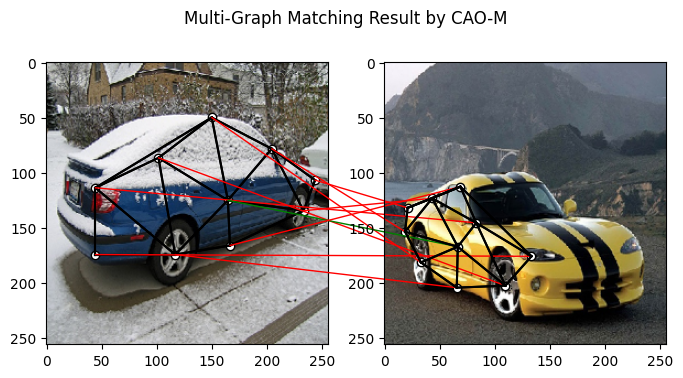

In [9]:
base_mat = copy.deepcopy(rrwm_mat)
tic = time.time()
cao_m_mat = pygm.multi_graph_solvers.cao(affinity_mat, base_mat, mode='memory')
cao_m_mat = pygm.linear_solvers.hungarian(cao_m_mat.reshape(-1, n, n)).reshape(m, m, n, n)
toc = time.time()
cao_m_acc, cao_m_src, cao_m_con = eval(cao_m_mat, gt_mat, affinity_mat, m, n)
cao_m_tim = toc - tic + rrwm_tim

plt.figure(figsize=(8, 4))
plt.suptitle('Multi-Graph Matching Result by CAO-M')
ax1 = plt.subplot(1, 2, 1)
plot_image_with_graph(img_list[a], kpts_list[a], adj_list[a])
ax2 = plt.subplot(1, 2, 2)
plot_image_with_graph(img_list[b], kpts_list[b], adj_list[b])
X = cao_m_mat[a, b]
for i in range(X.shape[0]):
    j = torch.argmax(X[i]).item()
    con = ConnectionPatch(xyA=kpts_list[a][:, i], xyB=kpts_list[b][:, j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red" if i != j else "green")
    plt.gca().add_artist(con)
# plt.savefig("CAO-M.png")
# plt.close()

Multi graph matching: CAO-T
See :func:`~pygmtools.multi_graph_solvers.cao` for the API reference.




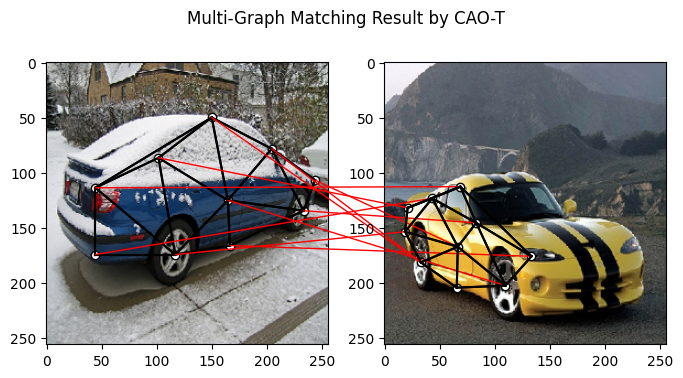

In [10]:
base_mat = copy.deepcopy(rrwm_mat)
tic = time.time()
cao_t_mat = pygm.multi_graph_solvers.cao(affinity_mat, base_mat, mode='time')
cao_t_mat = pygm.linear_solvers.hungarian(cao_t_mat.reshape(-1, n, n)).reshape(m, m, n, n)
toc = time.time()
cao_t_acc, cao_t_src, cao_t_con = eval(cao_t_mat, gt_mat, affinity_mat, m, n)
cao_t_tim = toc - tic + rrwm_tim

plt.figure(figsize=(8, 4))
plt.suptitle('Multi-Graph Matching Result by CAO-T')
ax1 = plt.subplot(1, 2, 1)
plot_image_with_graph(img_list[a], kpts_list[a], adj_list[a])
ax2 = plt.subplot(1, 2, 2)
plot_image_with_graph(img_list[b], kpts_list[b], adj_list[b])
X = cao_t_mat[a, b]
for i in range(X.shape[0]):
    j = torch.argmax(X[i]).item()
    con = ConnectionPatch(xyA=kpts_list[a][:, i], xyB=kpts_list[b][:, j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red" if i != j else "green")
    plt.gca().add_artist(con)
# plt.savefig("CAO-T.png")
# plt.close()

Multi graph matching: MGM-Floyd-M
See :func:`~pygmtools.multi_graph_solvers.mgm_floyd` for the API reference.




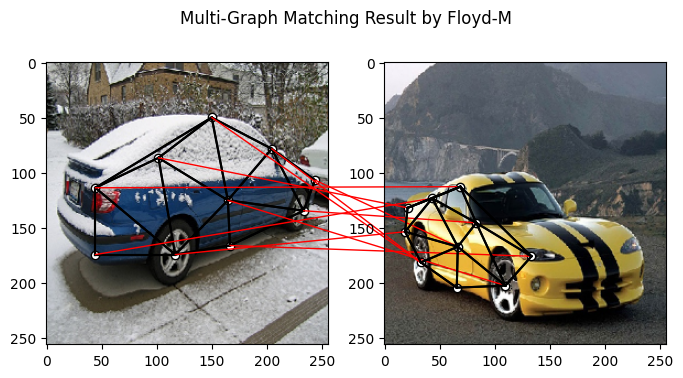

In [11]:
base_mat = copy.deepcopy(rrwm_mat)
tic = time.time()
floyd_m_mat = pygm.multi_graph_solvers.mgm_floyd(affinity_mat, base_mat, param_lambda=0.4, mode='memory')
floyd_m_mat = pygm.linear_solvers.hungarian(floyd_m_mat.reshape(-1, n, n)).reshape(m, m, n, n)
toc = time.time()
floyd_m_acc, floyd_m_src, floyd_m_con = eval(floyd_m_mat, gt_mat, affinity_mat, m, n)
floyd_m_tim = toc - tic + rrwm_tim

plt.figure(figsize=(8, 4))
plt.suptitle('Multi-Graph Matching Result by Floyd-M')
ax1 = plt.subplot(1, 2, 1)
plot_image_with_graph(img_list[a], kpts_list[a], adj_list[a])
ax2 = plt.subplot(1, 2, 2)
plot_image_with_graph(img_list[b], kpts_list[b], adj_list[b])
X = floyd_m_mat[a, b]
for i in range(X.shape[0]):
    j = torch.argmax(X[i]).item()
    con = ConnectionPatch(xyA=kpts_list[a][:, i], xyB=kpts_list[b][:, j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red" if i != j else "green")
    plt.gca().add_artist(con)
# plt.savefig("Floyd-M.png")
# plt.close()

Multi graph matching: MGM-Floyd-T
See :func:`~pygmtools.multi_graph_solvers.mgm_floyd` for the API reference.




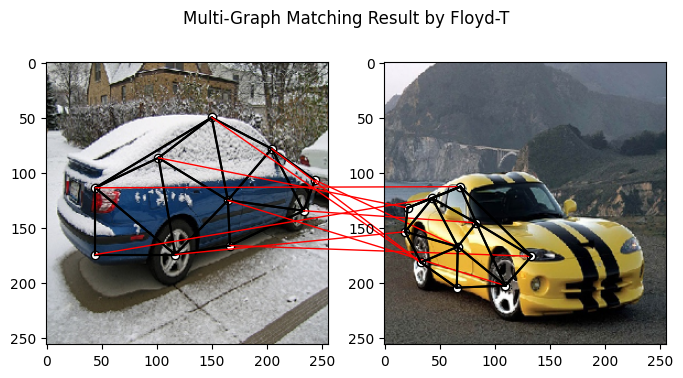

In [12]:
base_mat = copy.deepcopy(rrwm_mat)
tic = time.time()
floyd_t_mat = pygm.multi_graph_solvers.mgm_floyd(affinity_mat, base_mat, param_lambda=0.6, mode='time')
floyd_t_mat = pygm.linear_solvers.hungarian(floyd_t_mat.reshape(-1, n, n)).reshape(m, m, n, n)
toc = time.time()
floyd_t_acc, floyd_t_src, floyd_t_con = eval(floyd_t_mat, gt_mat, affinity_mat, m, n)
floyd_t_tim = toc - tic + rrwm_tim

plt.figure(figsize=(8, 4))
plt.suptitle('Multi-Graph Matching Result by Floyd-T')
ax1 = plt.subplot(1, 2, 1)
plot_image_with_graph(img_list[a], kpts_list[a], adj_list[a])
ax2 = plt.subplot(1, 2, 2)
plot_image_with_graph(img_list[b], kpts_list[b], adj_list[b])
X = floyd_t_mat[a, b]
for i in range(X.shape[0]):
    j = torch.argmax(X[i]).item()
    con = ConnectionPatch(xyA=kpts_list[a][:, i], xyB=kpts_list[b][:, j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red" if i != j else "green")
    plt.gca().add_artist(con)
# plt.savefig("Floyd-T.png")
# plt.close()